# **Estimating Cooling Capacities from Aerial Images Using CNNs**

Most of the Notebook is ready to run sumply by activating the cells from top down. **Some of the cells NEED INPUT FROM THE USER**, before running. These user input are marked as follows:

In [ ]:
#--------------------------USER--INPUT--------------------------------------------
#--------------------------USER--INPUT--------------------------------------------
""" USER INPUT HERE """
#--------------------------USER--INPUT--------------------------------------------
#--------------------------USER--INPUT--------------------------------------------

# **0) Choose device: CPU or GPU**

Out of experience running the model on a GPU is not essential to achieve fast detection.

In [1]:
# Check the provided GPU when using a GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# **1) Tile Input Maps**

In order for the model to be able to detect the CCs and CTs large images must be cropped. To detect objects in the edges we crop with an overlap of 80px. To save coordinates for later merging an xml-file is generated for each tile.

In [2]:
# Import dependencies

import cv2
import math
import xml.etree.ElementTree as xml
import glob
import os
from PIL import Image, ImageDraw

We have the possibility to either drag and drop input maps inside a new folder or to mount a Google Drive

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
# Set input directory for input maps, output directory for the tiles and coordinate-storage files

#--------------------------USER--INPUT--------------------------------------------
#--------------------------USER--INPUT--------------------------------------------
Input_Map_Directory = '/content/Input_Base_Maps/'
#--------------------------USER--INPUT--------------------------------------------
#--------------------------USER--INPUT--------------------------------------------


CCs_CTs_Folder = '/content/Detect_CCs_CTs/'
Save_Tiles_Directory = '/content/Detect_CCs_CTs/Cropped_Map_Tiles/'
Save_Tile_Coordinates_as_XML_Directory = '/content/Detect_CCs_CTs/Coordinates_Map_Tiles_XML/'

In [4]:
# When not using Google Drive create new Folders for the input maps and to store output tiles and coordinates in.
# Input maps can just be dragged inside the new folder to upload them

os.mkdir(Input_Map_Directory)
os.mkdir(CCs_CTs_Folder)
os.mkdir(Save_Tiles_Directory)
os.mkdir(Save_Tile_Coordinates_as_XML_Directory)

Set Scale for the input maps (= GSD = Ground sample distance)


In [5]:
# Set Image Type and Scale
#--------------------------USER--INPUT--------------------------------------------
#--------------------------USER--INPUT--------------------------------------------
Image_Type = 'jpg'

GSD_is_known = False  # Set True, when GSD is known. Set False, when GSD is unknown and shall be calculated

# When GSD is known type it here
GSD = 0.09  #[m/px]

# When GSD is not known measure real-world image width of the first image of the folder and type it into here
Map_Width = 152  #[m]

Tile_Overlap_Meters = 10
#--------------------------USER--INPUT--------------------------------------------
#--------------------------USER--INPUT--------------------------------------------





if GSD_is_known: # use input GSD
  GSD_Used = GSD
  print('GSD is set as known. Input-GSD = ' + str(GSD))
else: #calculate from real-world image width
  list_map_directory = os.listdir(Input_Map_Directory)
  List_Input_Map_Directory = [os.path.basename(x) for x in glob.glob(Input_Map_Directory + '*.' + Image_Type)]
  List_of_Maps_in_Input_Map_Directory_without_Extensions = [x.split('.')[0] for x in list_map_directory]
  list_length = len(List_of_Maps_in_Input_Map_Directory_without_Extensions)

  img_for_width = cv2.imread(Input_Map_Directory + List_of_Maps_in_Input_Map_Directory_without_Extensions[0] + '.jpg') # 512x512
  img_for_width_shape = img_for_width.shape
  GSD_Used = Map_Width / img_for_width_shape[0]
  print('Image ' + str(List_Input_Map_Directory[0]) + ' has width of ' + str(img_for_width_shape[0]) + ' pixels.')
  print('From that the GSD is calculated as: ' + str(GSD_Used) + ' m/px')



Image Test_Freiburg_Small_1.jpg has width of 1249 pixels.
From that the GSD is calculated as: 0.12169735788630905 m/px


Now run code to tile input maps

In [6]:
# Run code to tile all input maps and store cordinates as XML-files

def Create_XML_Tiles(filename, Tile_Name, Upper_Left_Coordinate_X, Upper_Left_Coordinate_Y, Lower_Right_Coordinate_X, Lower_Right_Coordinate_Y):
    # write entries
    root = xml.Element('Coordinates_Tiled_Map')
    Keyword_Tilenumber = Tile_Name
    #Keyword = str(Keyword_Tilenumber)
    c1 = xml.Element(Keyword_Tilenumber)
    root.append(c1)
    X_Coordinate = xml.SubElement(c1, 'x_upper_left')
    X_Coordinate.text = str(Upper_Left_Coordinate_X)
    Y_Coordinate = xml.SubElement(c1, 'y_upper_left')
    Y_Coordinate.text = str(Upper_Left_Coordinate_Y)
    X_Size = xml.SubElement(c1, 'x_lower_right')
    X_Size.text = str(Lower_Right_Coordinate_X)
    Y_Size = xml.SubElement(c1, 'y_lower_right')
    Y_Size.text = str(Lower_Right_Coordinate_Y)

    # write file
    tree = xml.ElementTree(root)
    with open(filename,'wb') as files:
        tree.write(files)


list_map_directory = os.listdir(Input_Map_Directory)
List_Input_Map_Directory = [os.path.basename(x) for x in glob.glob(Input_Map_Directory + '*.' + Image_Type)]
List_of_Maps_in_Input_Map_Directory_without_Extensions = [x.split('.')[0] for x in list_map_directory]
list_length = len(List_of_Maps_in_Input_Map_Directory_without_Extensions)
for x in range(0, list_length):
  print('Input Map: ' + List_of_Maps_in_Input_Map_Directory_without_Extensions[x])

  img = cv2.imread(Input_Map_Directory + List_of_Maps_in_Input_Map_Directory_without_Extensions[x] + '.' + Image_Type) # 512x512

  img_shape = img.shape
  Tile_Size = (512, 512)
  Offset = (432, 432)
  
  #print('Time Size: ' + str(Tile_Size) + ' pixels')
  #print('Overlap: ' + str(Tile_Size[0] - Offset[0]) + ' pixels')
  Number_Tiles_per_Image = 0

  for i in range(int(math.ceil(img_shape[0]/(Offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(Offset[0] * 1.0)))):
          cropped_img = img[Offset[1]*i:min(Offset[1]*i+Tile_Size[1], img_shape[0]), Offset[0]*j:min(Offset[0]*j+Tile_Size[0], img_shape[1])]
          # Debugging the tiles
          cv2.imwrite(Save_Tiles_Directory + List_of_Maps_in_Input_Map_Directory_without_Extensions[x] + '_' + str(i) + '_' + str(j) + '.jpg', cropped_img)

          Upper_Left_X = str(Offset[0]*j+Tile_Size[0] - 512)
          Upper_Left_Y = str(Offset[1]*i+Tile_Size[1] - 512)
          Lower_Right_X = str(min (Offset[0]*j+Tile_Size[0], img_shape[1]))
          Lower_Right_Y = str(min (Offset[1]*i+Tile_Size[1], img_shape[0]))
          
          Tile_Name = List_of_Maps_in_Input_Map_Directory_without_Extensions[x] + '_' + str(i) + '_' + str(j) + '.jpg'
          Map_Name = List_of_Maps_in_Input_Map_Directory_without_Extensions[x]
          Number_Tiles_per_Image +=1

          FileName = Save_Tile_Coordinates_as_XML_Directory + List_of_Maps_in_Input_Map_Directory_without_Extensions[x] + '_' + str(i) + '_' + str(j)

          #cv2.imwrite(FileName + '.jpg', cropped_img)
          XML_Name = FileName + '.xml'

          if __name__ == '__main__':
            Create_XML_Tiles(XML_Name, Map_Name, Upper_Left_X, Upper_Left_Y, Lower_Right_X, Lower_Right_Y)

  print('Number of Tiles of Input Map: ' + str(Number_Tiles_per_Image))

Input Map: Test_Freiburg_Small_1
Number of Tiles of Input Map: 12
Input Map: Test_Freiburg_Small_2
Number of Tiles of Input Map: 12


In [7]:
# Enlarge Input Images when they are smaller than 512x512 (on the edges)

import os
import glob
from PIL import Image, ImageDraw

BB_Input_Directory = Save_Tiles_Directory
BB_Resized_Directory = Save_Tiles_Directory

BB_List_Images_Input_Directory = [os.path.basename(x) for x in glob.glob(Save_Tiles_Directory + '*.jpg')]
BB_itemcounter = 0
for i in BB_List_Images_Input_Directory:
  BB_itemcounter +=1
print('Items in BB Input Directory: ' + str(BB_itemcounter))

for i in range(0, BB_itemcounter): # replace second number in range(0, 5) to the number of images in the folder
  BB_image_counter = i
  #List_Images_Input_Directory = [os.path.basename(x) for x in glob.glob(BB_Input_Directory + '*.png')]
  BB_list_directory = os.listdir(Save_Tiles_Directory)
  BB_List_Input_Directory_without_Extensions = [x.split('.')[0] for x in BB_list_directory]
  BB_image_path = Save_Tiles_Directory + BB_List_Input_Directory_without_Extensions[BB_image_counter] + '.jpg'
  BB_save_output_path = Save_Tiles_Directory + BB_List_Input_Directory_without_Extensions[BB_image_counter] + '.jpg'

  img1 = Image.open(BB_image_path)
  img2 = img1.crop( (0,0,512,512) )
  draw = ImageDraw.Draw(img2)
  draw.rectangle( (0,img1.height,512,512), fill="white" )
  draw.rectangle( (img1.width,0,512,512), fill="white" )

  del draw
  img2.save(BB_save_output_path, "JPEG", quality=100)
  
print('resize done')


Items in BB Input Directory: 24
resize done


# **2) Detect Compression Chillers and Cooling Towers**

To detect CCs and CTs we use a trained EfficientDet D0 model.
To runt eh EffDet model we first need to install the Tensorflow object detection API. Then we import the trained model and run the model for each tile.

**Install Tensorflow Object Detection API:**

In [8]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/FloBarth/models

Cloning into 'models'...
remote: Enumerating objects: 2798, done.
remote: Counting objects: 100% (2798/2798), done.
remote: Compressing objects: 100% (2475/2475), done.
remote: Total 2798 (delta 560), reused 1832 (delta 287), pack-reused 0
Receiving objects: 100% (2798/2798), 57.73 MiB | 33.46 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [9]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1534293 sha256=5b86ed2a30bbf8f0544b6fcb11d8f77e35a985d5e39a6a92a3af433182892f79
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9t839yz/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp37-none-any.whl size=20070 sha256=9023e6f12dda74e7e80a17450382607da4a567226a0f861965f7204d98ed0bcf
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=ea98a2e05c47757afebea30d97c347fd615481132b6377772ad84ecf6b43bc1e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built object-detection py-cpuinfo seqeval
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Success

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [10]:
# Show the Tensorflow Version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [11]:
# Run model builder test. Step is not needed every time when starting teh notebook.
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2021-03-25 11:02:44.584708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-03-25 11:02:48.389319: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-25 11:02:48.425716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-25 11:02:48.501983: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-25 11:02:48.502058: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (13c747047451): /proc/driver/nvidia/version does not exist
2021-03-25 11:02:48.502604: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devic

If future Tensorflow versions are incompatible with the model, please install Tensorflow Versions 2.1.0 / 2.3.0 or / 2.4.1. All these have been tested to work with the trained Models

In [12]:
# Import dependencies

import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
import pathlib
import xml.etree.ElementTree as ET

%matplotlib inline

Download the trained EfficientDet model

In [13]:
# Download the trained model from GitHub

if "EffDet_D0_CC_CT_Model" in pathlib.Path.cwd().parts:
  while "EffDet_D0_CC_CT_Model" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('EffDet_D0_CC_CT_Model').exists():
  !git clone --depth 1 https://github.com/FloBarth/EffDet_D0_CC_CT_Model

Cloning into 'EffDet_D0_CC_CT_Model'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [14]:
# Function to Load in Images
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [15]:
pipeline_file = '/content/EffDet_D0_CC_CT_Model/pipeline.config'
model_dir = '/content/EffDet_D0_CC_CT_Model/'

In [16]:
Final_Detections_Output_Directory = '/content/Final_Detections_Output/'

In [17]:
os.mkdir(Final_Detections_Output_Directory)

In [18]:
# recover the saved model
pipeline_file = '/content/EffDet_D0_CC_CT_Model/pipeline.config'
model_dir = '/content/EffDet_D0_CC_CT_Model/'

pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = '/content/EffDet_D0_CC_CT_Model/checkpoint/ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/EffDet_D0_CC_CT_Model/checkpoint/ckpt-0'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [19]:
# Define Labelmap by Hand:

category_index = {1: {'id': 1, 'name': 'CC'}, 2: {'id': 2, 'name': 'CT'}}

In [20]:
# Crop Bounding Boxes of Compression Chillers and Save Images to a Folder
def Crop_and_Save_Boundingbox_and_Save_Coordinates_and_Map_Tile(Image_XML_Path):
  open_image = Image.open(image_path)
  Image_Width, Image_Height = open_image.size
  index_calculator = -1

  for i in range(0, 100):
    index_calculator +=1
    Detection_Score = detections['detection_scores'].numpy()[0][index_calculator]

    if Detection_Score >= 0.3:  #check condition if detection scoe > 0.3
      if detections['detection_classes'].numpy()[0][index_calculator] == 0.0:  # Check for Compression Chillers
        X_min_normalized = detections['detection_boxes'].numpy()[0][index_calculator][1]  #Has to numbers between 1 and 100
        Y_min_normalized = detections['detection_boxes'].numpy()[0][index_calculator][0]
        X_max_normalized = detections['detection_boxes'].numpy()[0][index_calculator][3]
        Y_max_normalized = detections['detection_boxes'].numpy()[0][index_calculator][2]

        X_min_absolute = round(X_min_normalized * Image_Height) # round(...) to round off
        Y_min_absolute = round(Y_min_normalized * Image_Width)
        X_max_absolute = round(X_max_normalized * Image_Height)
        Y_max_absolute = round(Y_max_normalized * Image_Width)

        BB_X_Min = X_min_absolute
        BB_Y_Min = Y_min_absolute
        BB_X_Max = X_max_absolute - X_min_absolute
        BB_Y_Max = Y_max_absolute - Y_min_absolute

        Object_Index = str(index_calculator)
        #BB_Cropped_Directory = '/content/Detection_BBs_Cropped/'
        Boundingbox_Cropped_path = BB_Cropped_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_CC_' + Object_Index + '.png'

        # txt-file with all the detections:
        Bounding_Box_Textfile_Path = BB_Cropped_Coordinates_TXT + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_CC_' + Object_Index + '.txt'

        # txt-file for each bounding box
        Boundingbox_individual_Textfile_Path = BB_Individual_BBs_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_CC_' + Object_Index + '.txt'

        Cropped_to_Boundingbox = tf.image.crop_to_bounding_box( # Crop the NumPy Image without Bounding Boxes
        image_np, BB_Y_Min, BB_X_Min, BB_Y_Max, BB_X_Max
        )
        viz_utils.save_image_array_as_png(Cropped_to_Boundingbox, Boundingbox_Cropped_path)
        print('Boundingbox ' + Object_Index + ' saved to ' + Boundingbox_Cropped_path)
        #plt.imshow(Cropped_to_Boundingbox)


        tree = ET.parse(Image_XML_Path)
        root = tree.getroot()
        print(root)
        for child in root:
          print('Coordinates of the input image within the context of the larger input map: ')
          print('Input Map Name: ' + child.tag, child.attrib)
          print('x_upper_left: ' + root[0][0].text)
          print('y_upper_left: ' + root[0][1].text)
          print('x_lower_right: ' + root[0][2].text)
          print('y_lower_right: ' + root[0][3].text)
          
          Tile_Input_Map_Name = str(child.tag)
          Tile_x_upper_left = int(root[0][0].text)
          Tile_y_upper_left = int(root[0][1].text)
          Tile_x_lower_right = int(root[0][2].text)
          Tile_y_lower_right = int(root[0][3].text)

          print('Read code lines from xml file: ')
          print(Tile_Input_Map_Name)
          print(Tile_x_upper_left)
          print(Tile_y_upper_left)
          print(Tile_x_lower_right)
          print(Tile_y_lower_right)


        BB_X_Min_on_MAP = X_min_absolute + Tile_x_upper_left
        BB_Y_Min_on_MAP = Y_min_absolute + Tile_y_upper_left
        BB_X_Max_on_MAP = X_max_absolute + Tile_x_upper_left
        BB_Y_Max_on_MAP = Y_max_absolute + Tile_y_upper_left


         #Save TXT file for each Bounding Box 
        f = open(Boundingbox_individual_Textfile_Path, "w")
        # Map_Tile
        f.write(str(Tile_Input_Map_Name) + ' ')
        # Absolute Coordinates
        f.write('CC ')
        f.write(str(Detection_Score) + ' ')
        f.write(str(BB_Y_Min_on_MAP) + ' ')
        f.write(str(BB_X_Min_on_MAP) + ' ')
        f.write(str(BB_Y_Max_on_MAP) + ' ')
        f.write(str(BB_X_Max_on_MAP) + ' ')
        f.close()

    # --------------------------------------------------------------------------Cooling Towers:
    #Write file for CTs:
    if Detection_Score >= 0.5:
      if detections['detection_classes'].numpy()[0][index_calculator] == 1.0:  # Check for Compression Chillers
        X_min_normalized = detections['detection_boxes'].numpy()[0][index_calculator][1]  #Has to numbers between 1 and 100
        Y_min_normalized = detections['detection_boxes'].numpy()[0][index_calculator][0]
        X_max_normalized = detections['detection_boxes'].numpy()[0][index_calculator][3]
        Y_max_normalized = detections['detection_boxes'].numpy()[0][index_calculator][2]

        X_min_absolute = round(X_min_normalized * Image_Height) # round(...) to round off
        Y_min_absolute = round(Y_min_normalized * Image_Width)
        X_max_absolute = round(X_max_normalized * Image_Height)
        Y_max_absolute = round(Y_max_normalized * Image_Width)

        BB_Width = X_max_absolute - X_min_absolute
        BB_Height = Y_max_absolute - Y_min_absolute
        Mean_CT_Vent_Diameter = ((BB_Width + BB_Height) / 2) * 0.861448297
        Real_World_Vent_Diameter = Mean_CT_Vent_Diameter * GSD_Used # px * m/px
        CT_Cooling_Capacity = (672.07 * (Real_World_Vent_Diameter ** 2)) - (888.62 * Real_World_Vent_Diameter) + 628.64


        print('Cooling Capacity of the CT: ' + str(CT_Cooling_Capacity))
        print('Width = ' + str(BB_Width))
        print('Height = ' + str(BB_Height))
        print('Mean real world Diameter = ' + str(Real_World_Vent_Diameter))
        BB_X_Min = X_min_absolute
        BB_Y_Min = Y_min_absolute
        BB_X_Max = X_max_absolute - X_min_absolute
        BB_Y_Max = Y_max_absolute - Y_min_absolute


        Object_Index_CTs = str(index_calculator)
        # txt-file with all the detections:
        Bounding_Box_Textfile_Path_CTs = BB_Cropped_Coordinates_TXT + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_CT_' + Object_Index_CTs + '.txt'

        # txt-file for each bounding box
        Final_Detections_Output_CTs = '/content/Final_Detections_Output/' + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_CT_' + Object_Index_CTs + '.txt'

        tree = ET.parse(Image_XML_Path)
        root = tree.getroot()
        print(root)
        for child in root:
          print('Coordinates of the input image within the context of the larger input map: ')
          print('Input Map Name: ' + child.tag, child.attrib)
          print('x_upper_left: ' + root[0][0].text)
          print('y_upper_left: ' + root[0][1].text)
          print('x_lower_right: ' + root[0][2].text)
          print('y_lower_right: ' + root[0][3].text)
          
          Tile_Input_Map_Name = str(child.tag)
          Tile_x_upper_left = int(root[0][0].text)
          Tile_y_upper_left = int(root[0][1].text)
          Tile_x_lower_right = int(root[0][2].text)
          Tile_y_lower_right = int(root[0][3].text)

          print('Read code lines from xml file: ')
          print(Tile_Input_Map_Name)
          print(Tile_x_upper_left)
          print(Tile_y_upper_left)
          print(Tile_x_lower_right)
          print(Tile_y_lower_right)


        BB_X_Min_on_MAP = X_min_absolute + Tile_x_upper_left
        BB_Y_Min_on_MAP = Y_min_absolute + Tile_y_upper_left
        BB_X_Max_on_MAP = X_max_absolute + Tile_x_upper_left
        BB_Y_Max_on_MAP = Y_max_absolute + Tile_y_upper_left


        #Save TXT file for each Bounding Box 
        f = open(Final_Detections_Output_CTs, "w")
        # Map_Tile
        f.write(str(Tile_Input_Map_Name) + ' ')
        # Absolute Coordinates
        f.write('CT ')
        f.write(str(Detection_Score) + ' ')
        f.write(str(BB_Y_Min_on_MAP) + ' ')
        f.write(str(BB_X_Min_on_MAP) + ' ')
        f.write(str(BB_Y_Max_on_MAP) + ' ')
        f.write(str(BB_X_Max_on_MAP) + ' ')
        f.write(str(round(CT_Cooling_Capacity)))
        f.close()





In [21]:
# Set Input Directory and Output Directories
Input_Directory = Save_Tiles_Directory

Detect_Vents_Directory = '/content/Detect_Vents/'
Output_Directory = '/content/Detect_CCs_CTs/Saved_Detections_CC_CT/'
BB_Textfiles_Directory = '/content/Detect_CCs_CTs/Saved_Detections_CC_CT_TXT/'
BB_Individual_BBs_Directory = '/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/'
BB_Cropped_Directory = '/content/Detect_Vents/Saved_Detections_CC_CT_BBs/'
BB_Cropped_Coordinates_TXT = '/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/'

In [ ]:
# When not using Google Drive create new Folders for the input maps and to store output tiles and coordinates in.
# Input maps can just be dragged inside the new folder to upload them

os.mkdir(Detect_Vents_Directory)
os.mkdir(Output_Directory)
os.mkdir(BB_Textfiles_Directory)
os.mkdir(BB_Individual_BBs_Directory)
os.mkdir(BB_Cropped_Directory)

Run Detection

In [23]:
# Run Detection Over the Imges in folder

List_of_Images_in_Input_Directory = [os.path.basename(x) for x in glob.glob(Input_Directory + '*.jpg')]
itemcounter = 0
for i in List_of_Images_in_Input_Directory:
  itemcounter +=1
print('Items in Input Directory: ' + str(itemcounter))
Estimated_Detection_Time = (1.5 * itemcounter)/60
print('Estimated detection time on Google Colab: ' + str(round(Estimated_Detection_Time)) + ' minutes')

for i in range(0, itemcounter): # replace second number in range(0, 5) to the number of images in the folder
  image_counter = i
  List_of_Images_in_Input_Directory = [os.path.basename(x) for x in glob.glob(Input_Directory + '*.jpg')]
  list_directory = os.listdir(Input_Directory)
  List_of_Images_in_Input_Directory_without_Extensions = [x.split('.')[0] for x in list_directory]
  image_path = Input_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '.jpg'
  XML_Coordinates_Path = Save_Tile_Coordinates_as_XML_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '.xml'
  save_output_path = Output_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_Detections.png'

  image_np = load_image_into_numpy_array(image_path)

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.3,
        agnostic_mode=False,
  ) # Detection Threshold of 0.3 at this stage is only fro plotting the bounding boxes. The threshold for the saved detections is set in the respective functions themselves

  plt.figure(figsize=(10,10))
  plt.imshow(image_np_with_detections)
  plt.show()

  viz_utils.save_image_array_as_png(image_np_with_detections, save_output_path)
  


  #Read_XML_Coordinates(XML_Coordinates_Path)

  Boundingbox_Textfile_Path = BB_Textfiles_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter]
  

  
  #Save_Detections_as_Text(Boundingbox_Textfile_Path, List_of_Images_in_Input_Directory_without_Extensions[image_counter], XML_Coordinates_Path) # Save Detections as .txt
  #print('Detections:')
  #f = open(Boundingbox_Textfile_Path + '.txt', 'r') # check the file
  #print(f.read())

  #Calculate_Cooling_Capacity_of_CTs(GSD_Used)

  Crop_and_Save_Boundingbox_and_Save_Coordinates_and_Map_Tile(XML_Coordinates_Path)








Output hidden; open in https://colab.research.google.com to view.

# **3) Estiate Cooling Capacity**

# 3.1) Compression Chillers

To estimate teh cooling capacity of the CCs we use a second EfficientDet D0 model

In [24]:
# Set Input Directory with Detected CCs, Resize Directory to Save Images at 220x220px and Output Directory for Detection of Vents

Input_Directory_Vents = BB_Cropped_Directory
Input_Directory_Vents_White = '/content/CC_BBs_Resized/'
Output_Directory_Vents = '/content/Detected_Vents_Output/'


In [25]:
# Create directory to store Detections as .txt (otherwise the code to write textfiles won't work)
import os
os.mkdir(Input_Directory_Vents_White)
os.mkdir(Output_Directory_Vents)

In [26]:
# Enlarge images of CC-bounding-boxes and color the fringe white

import os
import glob
from PIL import Image, ImageDraw

BB_List_Images_Input_Directory = [os.path.basename(x) for x in glob.glob(Input_Directory_Vents + '*.png')]
BB_itemcounter = 0
for i in BB_List_Images_Input_Directory:
  BB_itemcounter +=1
print('Items in BB Input Directory: ' + str(BB_itemcounter))

for i in range(0, BB_itemcounter): # replace second number in range(0, 5) to the number of images in the folder
  BB_image_counter = i
  #List_Images_Input_Directory = [os.path.basename(x) for x in glob.glob(BB_Input_Directory + '*.png')]
  BB_list_directory = os.listdir(Input_Directory_Vents)
  BB_List_Input_Directory_without_Extensions = [x.split('.')[0] for x in BB_list_directory]
  BB_image_path = Input_Directory_Vents + BB_List_Input_Directory_without_Extensions[BB_image_counter] + '.png'
  BB_save_output_path = Input_Directory_Vents_White + BB_List_Input_Directory_without_Extensions[BB_image_counter] + '.png'

  img1 = Image.open(BB_image_path)
  img2 = img1.crop( (0,0,220,220) )
  draw = ImageDraw.Draw(img2)
  draw.rectangle( (0,img1.height,220,220), fill="white" )
  draw.rectangle( (img1.width,0,220,220), fill="white" )

  del draw
  img2.save(BB_save_output_path, "JPEG", quality=100)

Items in BB Input Directory: 15


Download and use the Trained Model to Detect Vents

In [27]:
# Download the Trained Model from GitHub

if "EffDet_CC_Vents_220px" in pathlib.Path.cwd().parts:
  while "EffDet_CC_Vents_220px" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('EffDet_CC_Vents_220px').exists():
  !git clone --depth 1 https://github.com/FloBarth/EffDet_CC_Vents_220px

Cloning into 'EffDet_CC_Vents_220px'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [28]:
# Define Labelmap
category_index = {'id': 1, 'name': 'Vent'}

In [29]:
# Recover the Saved Model for Detection of Vents
pipeline_file = '/content/EffDet_CC_Vents_220px/pipeline.config'
model_dir = '/content/EffDet_CC_Vents_220px/'

pipeline_config = pipeline_file
model_dir = '/content/EffDet_CC_Vents_220px/checkpoint/ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/EffDet_CC_Vents_220px/checkpoint/ckpt-0'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [30]:
# count number of vents in bounding box and save as List.
# The list is saved as CSV file after inference

def Count_Number_of_Vents_to_CSV(BB_Name, Tile_Name):
  Vent_Counter = 0
  for i in range(0, 100): # max 100 detections of EffDet tensor
    if detections['detection_scores'][0][i].numpy() > 0.3:
      Vent_Counter +=1
  print('Number of detected vents: ' + str(Vent_Counter))
  if Vent_Counter == 0:
    Cooling_Capacity_CCs = 0
  elif Vent_Counter <= 2:
    Cooling_Capacity_CCs = (73.383 * Vent_Counter) - 41.433
  else:
    Cooling_Capacity_CCs = (62.123 * Vent_Counter) - 63.781
  print('Estimated Cooling Capacity: ' + str(Cooling_Capacity_CCs) + ' kW')


  BB_Name_List.append(BB_Name)
  Tile_Name_List.append(Tile_Name)
  Detected_Vents_List.append(Vent_Counter)
  Cooling_Capacity_List.append(Cooling_Capacity_CCs)
  #Y_Min.append
  #X_Min.append
  #Y_Max.append
  #X_Max.append

  return BB_Name_List
  return Tile_Name_List
  return Detected_Vents_List
  return Cooling_Capacity_List

In [31]:
def Count_Vents():
  Vents_Counter = 0
  for i in range(0, 100): # max 100 detections of EffDet tensor
    if detections['detection_scores'][0][i].numpy() > 0.3:
      Vents_Counter +=1
  print('Number of detected vents: ' + str(Vents_Counter))
  if Vents_Counter == 0:
    Cooling_Capacity_CC = 0

  elif Vents_Counter <= 2:
    Cooling_Capacity_CC = (73.383 * Vents_Counter) - 41.433

  else:
    Cooling_Capacity_CC = (62.123 * Vents_Counter) - 63.781
  print('Estimated Cooling Capacity: ' + str(Cooling_Capacity_CC) + ' kW')


Run Detections on Resized CC-Images

Images in Input Directory: 15


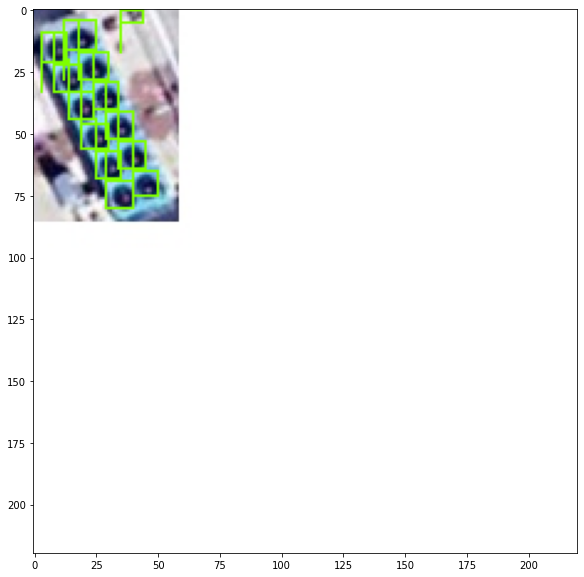

Number of detected vents: 13
Estimated Cooling Capacity: 743.818 kW
Test_Freiburg_Small_1_0_2_CC_1
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_2_CC_1.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.9843434
100
1245
186
1304
Estimated Cooling Capacity: 743.818 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_2_CC_1.txt


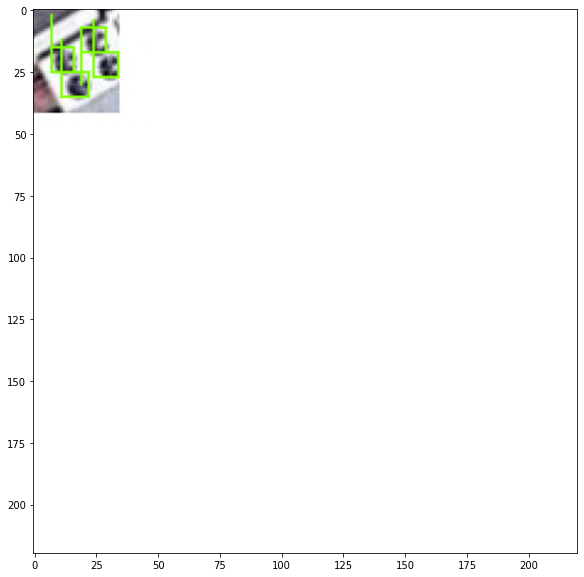

Number of detected vents: 4
Estimated Cooling Capacity: 184.71099999999998 kW
Test_Freiburg_Small_2_2_1_CC_3
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_1_CC_3.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.9688863
1067
908
1109
943
Estimated Cooling Capacity: 184.71099999999998 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_1_CC_3.txt


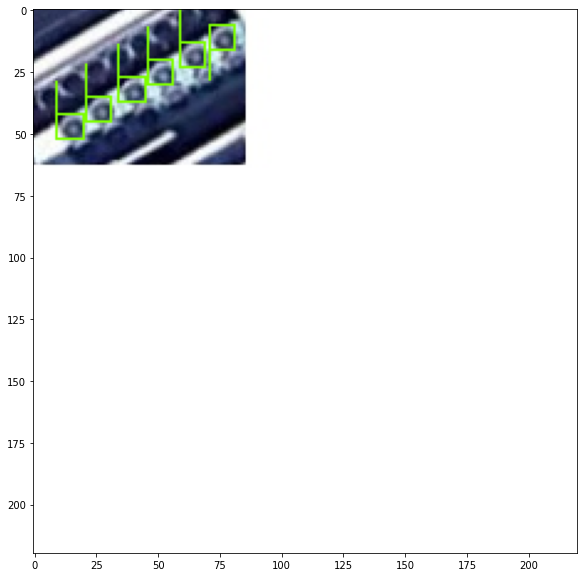

Number of detected vents: 6
Estimated Cooling Capacity: 308.957 kW
Test_Freiburg_Small_2_2_1_CC_2
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_1_CC_2.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.97307193
1033
685
1096
771
Estimated Cooling Capacity: 308.957 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_1_CC_2.txt


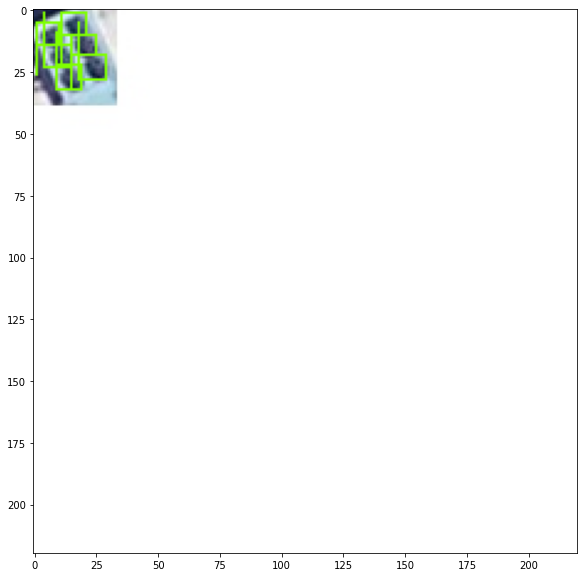

Number of detected vents: 6
Estimated Cooling Capacity: 308.957 kW
Test_Freiburg_Small_1_0_3_CC_1
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_3_CC_1.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.76621366
302
1339
341
1373
Estimated Cooling Capacity: 308.957 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_3_CC_1.txt


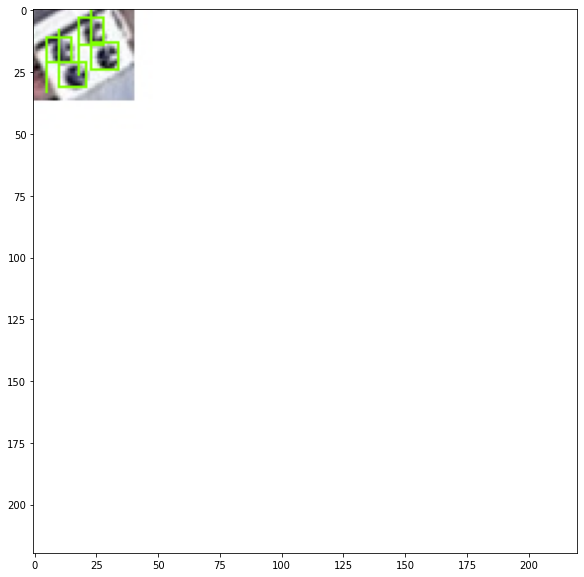

Number of detected vents: 4
Estimated Cooling Capacity: 184.71099999999998 kW
Test_Freiburg_Small_2_2_2_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_2_CC_0.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.9934405
1071
909
1108
950
Estimated Cooling Capacity: 184.71099999999998 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_2_CC_0.txt


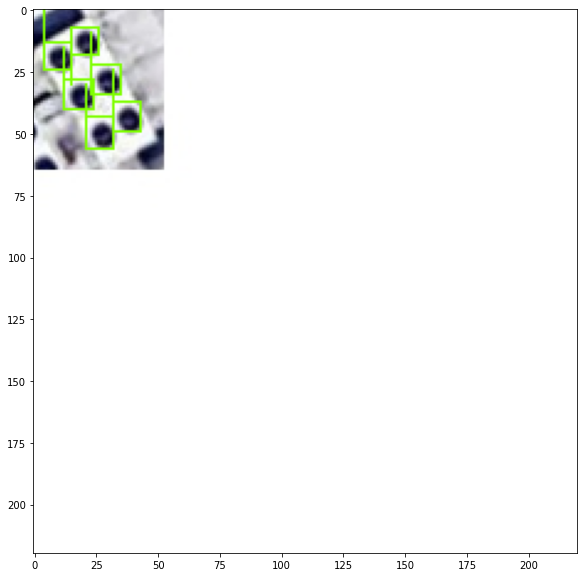

Number of detected vents: 6
Estimated Cooling Capacity: 308.957 kW
Test_Freiburg_Small_2_2_1_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_1_CC_0.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.99828714
1089
754
1154
807
Estimated Cooling Capacity: 308.957 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_1_CC_0.txt


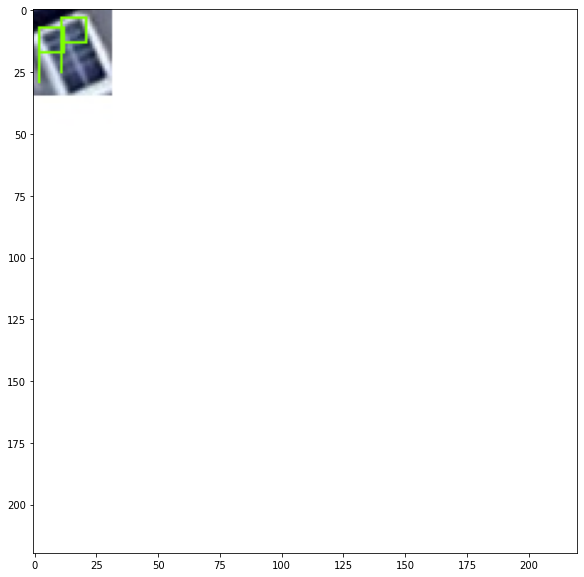

Number of detected vents: 2
Estimated Cooling Capacity: 105.333 kW
Test_Freiburg_Small_2_2_0_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_0_CC_0.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.66908205
990
103
1025
135
Estimated Cooling Capacity: 105.333 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_0_CC_0.txt


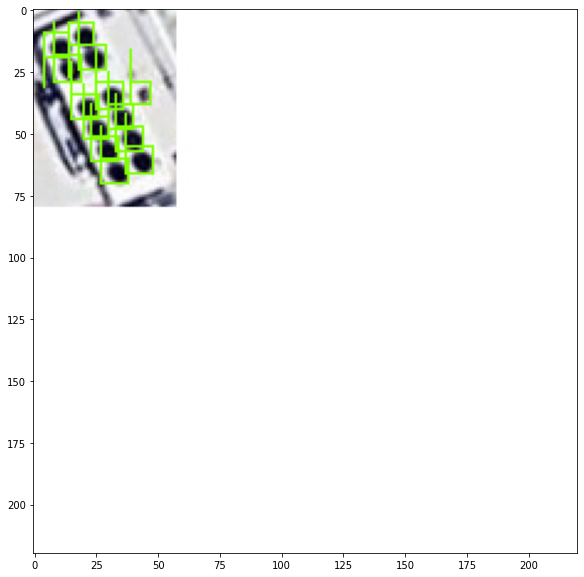

Number of detected vents: 13
Estimated Cooling Capacity: 743.818 kW
Test_Freiburg_Small_1_0_2_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_2_CC_0.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.9918591
199
1290
279
1348
Estimated Cooling Capacity: 743.818 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_2_CC_0.txt


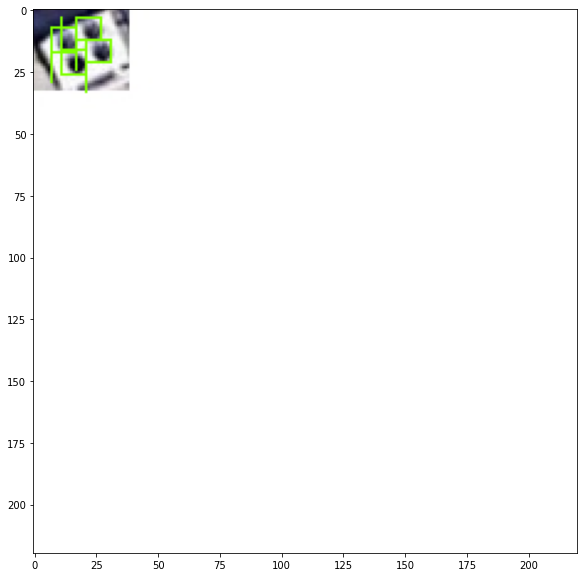

Number of detected vents: 4
Estimated Cooling Capacity: 184.71099999999998 kW
Test_Freiburg_Small_1_1_0_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_1_0_CC_0.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.9971445
484
103
517
142
Estimated Cooling Capacity: 184.71099999999998 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_1_0_CC_0.txt


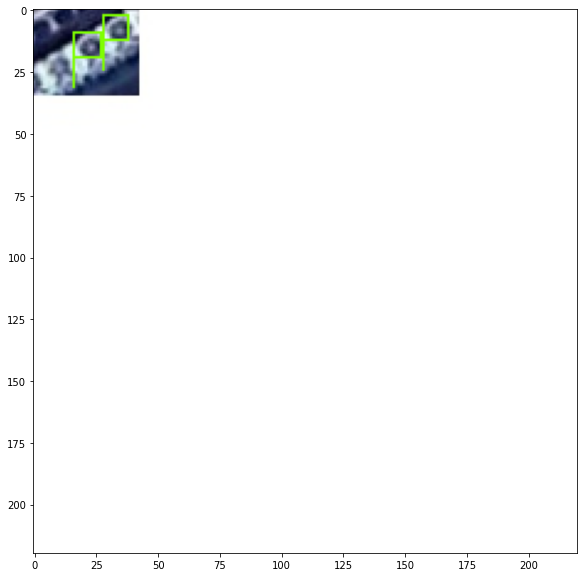

Number of detected vents: 2
Estimated Cooling Capacity: 105.333 kW
Test_Freiburg_Small_2_2_1_CC_4
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_1_CC_4.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.8020622
1090
637
1125
680
Estimated Cooling Capacity: 105.333 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_1_CC_4.txt


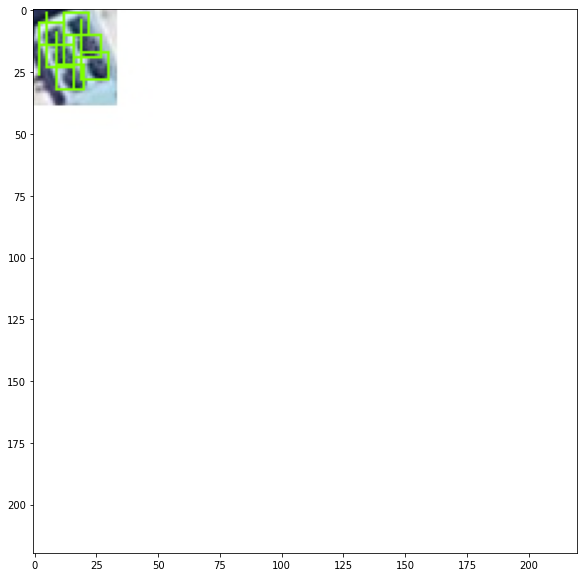

Number of detected vents: 6
Estimated Cooling Capacity: 308.957 kW
Test_Freiburg_Small_1_0_2_CC_2
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_2_CC_2.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.60124654
302
1338
341
1372
Estimated Cooling Capacity: 308.957 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_2_CC_2.txt


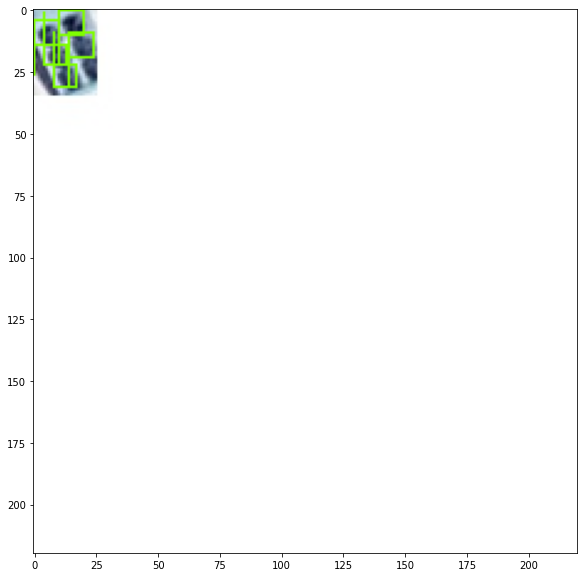

Number of detected vents: 5
Estimated Cooling Capacity: 246.834 kW
Test_Freiburg_Small_1_0_3_CC_2
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_3_CC_2.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.35093454
341
1358
376
1384
Estimated Cooling Capacity: 246.834 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_3_CC_2.txt


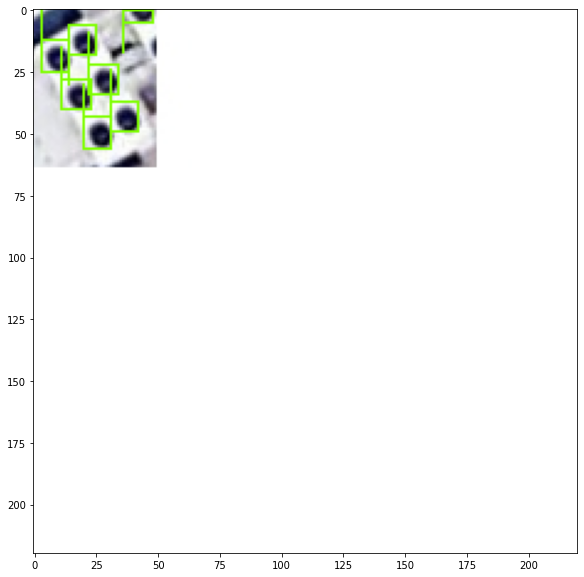

Number of detected vents: 7
Estimated Cooling Capacity: 371.08 kW
Test_Freiburg_Small_2_2_1_CC_1
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_2_2_1_CC_1.txt
Map: Test_Freiburg_Small_2
Type: CC
Thresh: 0.9965321
1109
721
1173
771
Estimated Cooling Capacity: 371.08 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_2_2_1_CC_1.txt


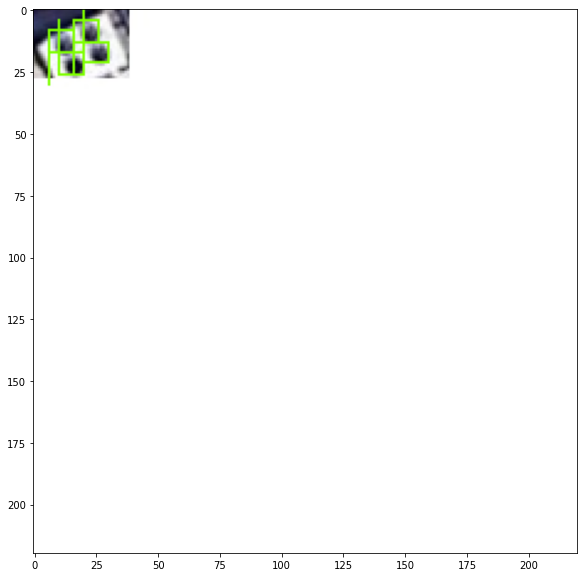

Number of detected vents: 4
Estimated Cooling Capacity: 184.71099999999998 kW
Test_Freiburg_Small_1_0_0_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_0_CC_0.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.95734775
483
104
511
143
Estimated Cooling Capacity: 184.71099999999998 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_0_CC_0.txt


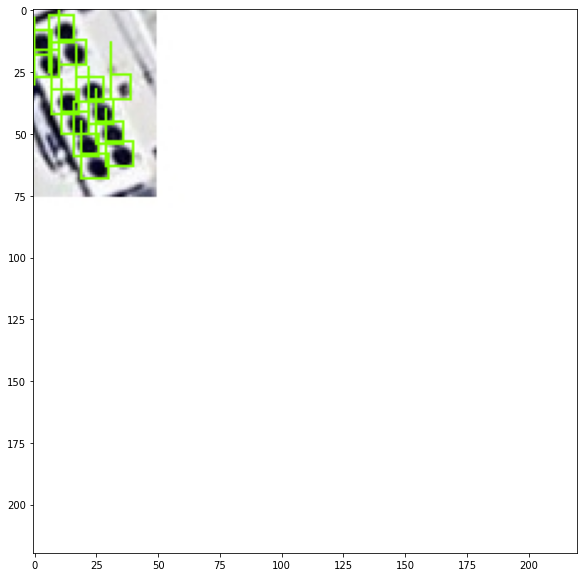

Number of detected vents: 13
Estimated Cooling Capacity: 743.818 kW
Test_Freiburg_Small_1_0_3_CC_0
/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/Test_Freiburg_Small_1_0_3_CC_0.txt
Map: Test_Freiburg_Small_1
Type: CC
Thresh: 0.9871955
201
1298
277
1348
Estimated Cooling Capacity: 743.818 kW
Final Output Textfile: /content/Final_Detections_Output/Test_Freiburg_Small_1_0_3_CC_0.txt


In [32]:
# Run detection

#BB_Name_List = ['Bounding_Box']
#Tile_Name_List = ['Tile_Name']
#Detected_Vents_List = ['Detected Circles']
#Cooling_Capacity_List = ['Cooling Capacity [kW]']



List_of_Images_in_Input_Directory = [os.path.basename(x) for x in glob.glob(Input_Directory_Vents_White + '*.png')]
itemcounter = 0
for i in List_of_Images_in_Input_Directory:
  itemcounter +=1
print('Images in Input Directory: ' + str(itemcounter))


for i in range(0, itemcounter):
  image_counter = i
  List_of_Images_in_Input_Directory = [os.path.basename(x) for x in glob.glob(Input_Directory_Vents_White + '*.png')]
  list_directory = os.listdir(Input_Directory_Vents_White)
  List_of_Images_in_Input_Directory_without_Extensions = [x.split('.')[0] for x in list_directory]
  image_path = Input_Directory_Vents_White + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '.png'
  save_output_path = Output_Directory_Vents + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '_detections.png'

  image_np = load_image_into_numpy_array(image_path)

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.3,
        agnostic_mode=False,
        line_thickness=1,
        skip_labels=True,
        skip_scores=True,
  )

  plt.figure(figsize=(10,10))
  plt.imshow(image_np_with_detections)
  plt.show()
  

  Vents_Counter = 0
  for i in range(0, 100): # max 100 detections of EffDet tensor
    if detections['detection_scores'][0][i].numpy() > 0.3:
      Vents_Counter +=1
  print('Number of detected vents: ' + str(Vents_Counter))
  if Vents_Counter == 0:
    Cooling_Capacity_CC = 0

  elif Vents_Counter <= 2:
    Cooling_Capacity_CC = (73.383 * Vents_Counter) - 41.433

  else:
    Cooling_Capacity_CC = (62.123 * Vents_Counter) - 63.781
  print('Estimated Cooling Capacity: ' + str(Cooling_Capacity_CC) + ' kW')
  
  
  
# Now we need to read the BBs txt-file to get the input map name and the coordinates of the BB.
# Then we write new files for each BB including the Input Map name to plot the detections on, the coordinates, number of vents and the cooling capacity

  Matching_BB_TXT_File = '/content/Detect_Vents/Saved_Detections_BBs_Coordinates_TXT/' + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '.txt'
  print(List_of_Images_in_Input_Directory_without_Extensions[image_counter])
  print(Matching_BB_TXT_File)

  # read txt file

  def Convert(string_Input): 
        li = list(string_Input.split(" ")) # Split by sign
        return li

  with open(Matching_BB_TXT_File) as fl:
      file_contents = [x.rstrip() for x in fl]
      for i in range (0, len(file_contents)):
        list_file_content = Convert(file_contents[i])
        np_array=np.asarray(list_file_content)
        # reshape array into 4 rows x 2 columns, and transpose the result
        reshaped_array = np_array.reshape(1, 7).T 

        Input_Map_Name = list_file_content[0]
        Chiller_Type = list_file_content[1]
        Detection_Threshold = list_file_content[2]
        absolute_upper_left_y = list_file_content[3]
        absolute_upper_left_x = list_file_content[4]
        absolute_lower_right_y = list_file_content[5]
        absolute_lower_right_x = list_file_content[6]
        print('Map: ' + Input_Map_Name)
        print('Type: ' + Chiller_Type)
        print('Thresh: ' + Detection_Threshold)
        print(absolute_upper_left_y)
        print(absolute_upper_left_x)
        print(absolute_lower_right_y)
        print(absolute_lower_right_x)


  print('Estimated Cooling Capacity: ' + str(Cooling_Capacity_CC) + ' kW')




  # Now write a new file in the directory 'Final_Detections_Output_Directory' consisting of: Input_Map_Name, Chiller-Type, Coordinates and Cooling_Capacity

  Final_Output_Textfile = Final_Detections_Output_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter] + '.txt'
  print('Final Output Textfile: ' + Final_Output_Textfile)

  f = open(Final_Output_Textfile, "w")
  f.write(str(Input_Map_Name) + ' ')
  f.write(str(Chiller_Type) + ' ')
  f.write(str(Detection_Threshold) + ' ')
  f.write(str(absolute_upper_left_y) + ' ')
  f.write(str(absolute_upper_left_x) + ' ')
  f.write(str(absolute_lower_right_y) + ' ')
  f.write(str(absolute_lower_right_x) + ' ')
  f.write(str(round(Cooling_Capacity_CC)))
  f.close


  #viz_utils.save_image_array_as_png(image_np_with_detections, save_output_path)

  #Boundingbox_Textfile_Path = BB_Textfiles_Directory + List_of_Images_in_Input_Directory_without_Extensions[image_counter]
  #Save_Detections_as_Text(Boundingbox_Textfile_Path) # Save Detections as .txt

  #Count_Number_of_Vents_to_CSV(image_path, Tile_Name)
  #print(image_path)

# write csv with detected vents
#rows = zip(BB_Name_List, Tile_Name_List, Detected_Vents_List, Cooling_Capacity_List)
#import csv

#with open('/content/Detected_Vents_EffDet.csv', "w") as f:
    #writer = csv.writer(f)
    #for row in rows:
        #writer.writerow(row)


**Append Cooling Capacity of the CTs to the csv-file**

In [ ]:
#def Read_Coordinates_from_TXT_File_and_Append_to_List:

# given: CSV: List of BB-name, Number of Vents, Cooling Capacity
          # TXT-files with CCs and CTs
# Wanted: Merge coordinates of the CCs from the txt-files with the above lists of bb-name, vents and cooling capacity.
          # therefore check if the name of the BB-Image fits.

          # append the CTs to the list
Name_List_CCs = ['Image']
Y_Min_Abs_List = ['Y_Min_Abs']
X_Min_Abs_List = ['X_Min_Abs']
Y_Max_Abs_List = ['Y_Max_Abs']
X_Max_Abs_List = ['Y_Max_Abs']


# input: image name list, detected vents list, cooling capacity list
def Read_TXT_Data (TXT_Input, Blank_Name_Input, Matching_BB_Name):
  def Convert(string_Input): 
      li = list(string_Input.split(" ")) # Split by sign
      return li

  with open(TXT_Input) as fl:
        file_contents = [x.rstrip() for x in fl]
        print('Check for Image: ' + Blank_Name_Input)
        for i in range (0, len(file_contents)):
          list_file_content = Convert(file_contents[i])
          np_array=np.asarray(list_file_content)
          # reshape array into 4 rows x 2 columns, and transpose the result
          reshaped_array = np_array.reshape(1, 13).T 
          Image_Name = list_file_content[0]
          Cropped_BB_Image_Name = list_file_content[1]
          Chiller_Type = list_file_content[2]
          upper_left_y = list_file_content[4]
          upper_left_x = list_file_content[5]
          lower_right_y = list_file_content[6]
          lower_right_x = list_file_content[7]

          absolute_upper_left_y = list_file_content[8]
          absolute_upper_left_x = list_file_content[9]
          absolute_lower_right_y = list_file_content[10]
          absolute_lower_right_x = list_file_content[11]

          Cooling_Capacity = list_file_content[12]


          if Matching_BB_Name in Image_Name:
            if Chiller_Type == 'CC':
              print('Success! Match found')
              print('Matching BB Image Name: ' + Cropped_BB_Image_Name + '.png')
              print('Cooling Capacity(expected zero): ' + str(Cooling_Capacity))
              # Add the coordinates and coolingcapacities to lists

              Name_List_CCs.append(Image_Name)
              Y_Max_Abs_List.append(absolute_upper_left_y)
              X_Min_Abs_List.append(absolute_upper_left_x)
              Y_Max_Abs_List.append(absolute_lower_right_y)
              X_Min_Abs_List.append(absolute_lower_right_x)


List_of_TXT_Files_in_Input_Directory = [os.path.basename(x) for x in glob.glob(BB_Textfiles_Directory + '*.txt')]
number_of_textfiles = 0
for y in List_of_TXT_Files_in_Input_Directory:
  number_of_textfiles +=1
print('Textfiles in directory: ' + str(number_of_textfiles)) # How many Textfiles are there?



for i in range(0, len(Image_Name_List)):
  print(Image_Name_List[i]) # --> one image name for each i
  print(Detected_Vents_List[i])
  print(Cooling_Capacity_List[i])
  #print('-------------------------------------------')
  
  # now check the text files#
  for j in range(0, number_of_textfiles):
      image_counter = j
      List_of_TXT_Files_in_Input_Directory = [os.path.basename(x) for x in glob.glob(BB_Textfiles_Directory + '*.txt')]
      list_dir = os.listdir(BB_Textfiles_Directory)
      List_of_TXT_Files_in_Input_Directory_without_Extensions = [x.split('.')[0] for x in list_dir]
      Text_paths = BB_Textfiles_Directory + List_of_TXT_Files_in_Input_Directory_without_Extensions[image_counter] + '.txt'

      Read_TXT_Data (Text_paths, List_of_TXT_Files_in_Input_Directory[image_counter], List_of_TXT_Files_in_Input_Directory_without_Extensions[image_counter])
      
      
      print('--------------')
  print('------------------------------------------------------------------')
    
    #if name matches check if it is a CC
    # add all the CCs to the list
print(Name_List_CCs)  
print(Image_Name_List) 

# **4) Merge Detections and Cooling Capacity with Input Maps and create a CSV for All Detections**

In [33]:
# create output folder
os.mkdir('/content/Output_Base_Maps')

In [34]:
# Copy all the input maps to the newly created output map folder

List_of_Input_Maps= [os.path.basename(x) for x in glob.glob('/content/Input_Base_Maps/' + '*.jpg')]
number_of_maps = 0
for y in List_of_Input_Maps:
  number_of_maps +=1
for i in range(0, number_of_maps):
  Input_Map_Path = '/content/Input_Base_Maps/' + str(List_of_Input_Maps[i])
  Output_Map_Path = '/content/Output_Base_Maps/' + str(List_of_Input_Maps[i])
  img1 = Image.open(Input_Map_Path)
  img1.save(Output_Map_Path, "JPEG", quality=100)


Import Text-Fonts for Plotting Detections onto Maps

In [35]:
!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSans-hinted.zip"

--2021-03-25 11:07:57--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSans-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.134.128, 2607:f8b0:400c:c00::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.134.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16796031 (16M) [application/zip]
Saving to: ‘NotoSans-hinted.zip’

NotoSans-hinted.zip 100%[===================>]  16.02M  43.9MB/s    in 0.4s    

2021-03-25 11:07:58 (43.9 MB/s) - ‘NotoSans-hinted.zip’ saved [16796031/16796031]



In [36]:
os.mkdir('/content/fonts')

In [37]:
# unzip downloaded files
!unzip NotoSans-hinted.zip -d /content/fonts

Archive:  NotoSans-hinted.zip
  inflating: /content/fonts/LICENSE_OFL.txt  
  inflating: /content/fonts/NotoSans-Black.ttf  
  inflating: /content/fonts/NotoSans-BlackItalic.ttf  
  inflating: /content/fonts/NotoSans-Bold.ttf  
  inflating: /content/fonts/NotoSans-BoldItalic.ttf  
  inflating: /content/fonts/NotoSans-Condensed.ttf  
  inflating: /content/fonts/NotoSans-CondensedBlack.ttf  
  inflating: /content/fonts/NotoSans-CondensedBlackItalic.ttf  
  inflating: /content/fonts/NotoSans-CondensedBold.ttf  
  inflating: /content/fonts/NotoSans-CondensedBoldItalic.ttf  
  inflating: /content/fonts/NotoSans-CondensedExtraBold.ttf  
  inflating: /content/fonts/NotoSans-CondensedExtraBoldItalic.ttf  
  inflating: /content/fonts/NotoSans-CondensedExtraLight.ttf  
  inflating: /content/fonts/NotoSans-CondensedExtraLightItalic.ttf  
  inflating: /content/fonts/NotoSans-CondensedItalic.ttf  
  inflating: /content/fonts/NotoSans-CondensedLight.ttf  
  inflating: /content/fonts/NotoSans-Condens

In [39]:
# fetch the name of font that was installed
#import matplotlib.font_manager as fm

fnt = ImageFont.truetype("/content/fonts/NotoSans-Black.ttf", 11)

**Open all detection textfiles and perform Non-Max suppression to delete doubled objects in the overlap areas. Then plot detections onto the input maps and create a CSV file with all detected objects.**

In [43]:
# Create dictionary with Chiller-Types
Chiller_Type_Dictionary_Str_to_Int = {'CC': 0, 'CT': 1,}
Chiller_Type_Dictionary_Int_to_Str = {0: 'CC', 1: 'CT',}

In [41]:
# Non-Max Suppression Function

# import the necessary packages
import numpy as np


# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,3]
	y1 = boxes[:,4]
	x2 = boxes[:,5]
	y2 = boxes[:,6]
  
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	  # return only the bounding boxes that were picked using the
	  # integer data type
	return boxes[pick].astype("float")


In [44]:
# Open all the textfiles from the detections and perform Non-max Suppression
import glob
import os
import numpy as np

np.set_printoptions(precision=1)

Detections_Array = [1, 0, 0, 0, 0, 0, 0, 0] # This is the new array to plot detections from
Map_Name_List = ['Input Map Name']
Map_Name_Code = 0

# Create CSV-file for all Input Maps
# The CSV contains of:
# Input_Map, Object_Type, Detection_Threshold, Cooling_Capacity, X_Min, Y_Min, X_Max, Y_Max
Input_Map_List = ['Input Map']
Object_Type_List = ['Object Type']
Detection_Threshold_List = ['Detection Threshold']
Cooling_Capacity_List = ['Cooling Capacity [kW]']
X_Min_List = ['X_Min']
Y_Min_List = ['Y_Min']
X_Max_List = ['X_Max']
Y_Max_List = ['Y_Max']

# Create dictionaries to assign a number to all input maps and vice versa
Map_Dictionary_Str_to_Int = {'Dicctionary_Name': 'Assigned_Number'} # create dictionaries to assign numbers to map names
Map_Dictionary_Int_to_Str = {'Assigned_Number': 'Dicctionary_Name'}


List_All_Final_Detections_Filepaths = [os.path.basename(x) for x in glob.glob('/content/Final_Detections_Output/' + '*.txt')]      # read all the files in Final_Detections_Output folder

for q in range(0, len(List_All_Final_Detections_Filepaths)):
  Final_Detections_Filepath = '/content/Final_Detections_Output/' + str(List_All_Final_Detections_Filepaths[q])

  #read the textfile
  def Convert(string_Input): 
    li = list(string_Input.split(" ")) # Split by sign
    return li

  with open(Final_Detections_Filepath) as fl:
    file_contents = [x.rstrip() for x in fl]
    for i in range (0, len(file_contents)):
      list_file_content = Convert(file_contents[i])
      np_array=np.asarray(list_file_content)
      # reshape array into 4 rows x 2 columns, and transpose the result
      reshaped_array = np_array.reshape(1, 8).T 

      Input_Map_Name_for_Plotting = list_file_content[0]
      Chiller_Type = list_file_content[1]
      Detection_Threshold = list_file_content[2]
      absolute_upper_left_y = list_file_content[3]
      absolute_upper_left_x = list_file_content[4]
      absolute_lower_right_y = list_file_content[5]
      absolute_lower_right_x = list_file_content[6]
      Cooling_Capacity = list_file_content[7]


      if str(Input_Map_Name_for_Plotting) not in Map_Name_List: # Append to dictionary of Map names
        Map_Name_Code +=1
        Map_Name_List.append(Input_Map_Name_for_Plotting)

        Map_Dictionary_Str_to_Int[Input_Map_Name_for_Plotting] = Map_Name_Code
        Map_Dictionary_Int_to_Str[Map_Name_Code] = Input_Map_Name_for_Plotting

      if Chiller_Type == 'CC':
        Chiller_Type_Code = 0
      else:
        Chiller_Type_Code = 1
      #create list of input map names --> check list, and for every newly occuring name generate new Map-Code

      # Add the Items to an array:
      NewRow = [int(Map_Dictionary_Str_to_Int[Input_Map_Name_for_Plotting]), int(Chiller_Type_Code), float(Detection_Threshold), int(absolute_upper_left_y), int(absolute_upper_left_x), int(absolute_lower_right_y), int(absolute_lower_right_x), int(Cooling_Capacity)] # to add multiple elements the NewRow needs to be inside a loop, whch constantly replaces the NewRow, adds them to the array, changes again and adds again
      Detections_Array = np.vstack([Detections_Array, NewRow])
#print(Detections_Array)


# Loop over each line in Detections_Array and extract each line with the same Map-Code
# Add all lines to a new array, perform Non-Max Suppression.
# Then save the array and clear it to load in data for the next map.

Map_Code_Counter = 0 # counts through all the generated map codes
for n in range(0, len(Map_Dictionary_Str_to_Int)-1): # For loop to find all lines in the array that fit the current Map-Code
  # Current Map Code to generate a new array for:
  Map_Code_Counter +=1
  # Create empty array with detections for each map code
  Non_Max_Array = [1, 0, 0, 0, 0, 0, 0, 0] 
  for x in range(0, len(Detections_Array)):
      if Detections_Array[x][0] == Map_Code_Counter: # If statement to check if the current line fits the current map code
        # add the line to the new array:
        NewRow = Detections_Array[x]
        #print('current line: ' + str(NewRow))
        Non_Max_Array = np.vstack([Non_Max_Array, NewRow])
        #Non_Max_Array = np.delete()
        #np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
  #print('Array for the current Map with code: ' + str(Map_Code_Counter) + str(Non_Max_Array))
  # Perform Non-Max suprpession:
  Non_Max_Suppressed_Detections_Array = non_max_suppression_fast(Non_Max_Array, 0.8) # Threshold
  print('Non-Max Suppressed Array for Map: ' + str(Map_Code_Counter))
  print(str(Non_Max_Suppressed_Detections_Array))

  # Plot Detections of each Map Array onto the Map
  
  for q in range(0, len(Non_Max_Suppressed_Detections_Array)):
    Input_Map_Name_for_Plotting = Map_Dictionary_Int_to_Str[Non_Max_Suppressed_Detections_Array[q][0]]
    print(Input_Map_Name_for_Plotting)
    Chiller_Type = Chiller_Type_Dictionary_Int_to_Str[Non_Max_Suppressed_Detections_Array[q][1]]
    Detection_Threshold = Non_Max_Suppressed_Detections_Array[q][2]
    absolute_upper_left_y = Non_Max_Suppressed_Detections_Array[q][3]
    absolute_upper_left_x = Non_Max_Suppressed_Detections_Array[q][4]
    absolute_lower_right_y = Non_Max_Suppressed_Detections_Array[q][5]
    absolute_lower_right_x = Non_Max_Suppressed_Detections_Array[q][6]
    Cooling_Capacity = Non_Max_Suppressed_Detections_Array[q][7]
    if not Cooling_Capacity == 0:
      #generate name of the input map to plot on
      Input_Map_Filename = cv2.imread('/content/Output_Base_Maps/' + Input_Map_Name_for_Plotting + '.' + Image_Type) 
      print(Input_Map_Filename)
      Final_Output_Map_Name = ('/content/Output_Base_Maps/' + Input_Map_Name_for_Plotting + '.' + Image_Type) 
      print(Final_Output_Map_Name)

      # Color in BGR 
      color = (255, 80, 80) 
      # Line thickness of 2 px 
      thickness = 2
            
      start_point = (int(absolute_upper_left_x), int(absolute_upper_left_y))
      end_point = (int(absolute_lower_right_x), int(absolute_lower_right_y))
      print(start_point)
      print(end_point)
      image = cv2.rectangle(Input_Map_Filename, start_point, end_point, color, thickness)
      cv2.imwrite(Final_Output_Map_Name, image) 

      # Add Label with Cooling Capacity:
      img = Image.open(Final_Output_Map_Name)
      x_Label = int(absolute_upper_left_x)
      y_Label = int(absolute_upper_left_y) - 16
      Label_Text = str(Chiller_Type) + ': ' + str(Cooling_Capacity) + ' kW'
            
      draw = ImageDraw.Draw(img) 
      draw.text((x_Label, y_Label),Label_Text ,(0,190,0), fnt) # Color in RGB

      img.save(Final_Output_Map_Name)

      # Append Non-Max suppresed detections to a list to create a CSV file
      Input_Map_List.append(Input_Map_Name_for_Plotting)
      Object_Type_List.append(Chiller_Type)
      Detection_Threshold_List.append(Detection_Threshold)
      Cooling_Capacity_List.append(Cooling_Capacity)
      X_Min_List.append(absolute_upper_left_x)
      Y_Min_List.append(absolute_upper_left_y)
      X_Max_List.append(absolute_lower_right_x)
      Y_Max_List.append(absolute_lower_right_y)

# Create CSV out of the Non-Max suppressed detection lists
rows = zip(Input_Map_List, Object_Type_List, Detection_Threshold_List, Cooling_Capacity_List, X_Min_List, Y_Min_List, X_Max_List, Y_Max_List)
import csv

with open('/content/Final_Cooling_Capacity_Estimation.csv', "a") as f:
  writer = csv.writer(f)
  for row in rows:
    writer.writerow(row)

Non-Max Suppressed Array for Map: 1
[[1.0e+00 1.0e+00 1.0e+00 2.6e+02 1.2e+03 3.0e+02 1.2e+03 1.0e+04]
 [1.0e+00 1.0e+00 1.0e+00 2.8e+02 1.2e+03 3.2e+02 1.2e+03 9.9e+03]
 [1.0e+00 0.0e+00 9.9e-01 1.1e+03 9.1e+02 1.1e+03 9.5e+02 1.8e+02]
 [1.0e+00 0.0e+00 1.0e+00 1.1e+03 7.5e+02 1.2e+03 8.1e+02 3.1e+02]
 [1.0e+00 0.0e+00 1.0e+00 1.1e+03 7.2e+02 1.2e+03 7.7e+02 3.7e+02]
 [1.0e+00 0.0e+00 9.7e-01 1.0e+03 6.8e+02 1.1e+03 7.7e+02 3.1e+02]
 [1.0e+00 0.0e+00 8.0e-01 1.1e+03 6.4e+02 1.1e+03 6.8e+02 1.0e+02]
 [1.0e+00 1.0e+00 1.0e+00 5.1e+02 6.4e+02 5.4e+02 6.8e+02 7.9e+03]
 [1.0e+00 0.0e+00 6.7e-01 9.9e+02 1.0e+02 1.0e+03 1.4e+02 1.0e+02]
 [1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]]
Test_Freiburg_Small_2
[[[187 182 184]
  [189 184 186]
  [193 188 190]
  ...
  [197 197 203]
  [202 199 208]
  [201 198 207]]

 [[189 184 186]
  [191 186 188]
  [195 190 192]
  ...
  [186 186 192]
  [199 196 205]
  [203 200 209]]

 [[190 185 187]
  [196 191 193]
  [196 191 193]
  ...
  [177 17

**All detected objects are now plotted onto the input maps. The final maps are in the folder /content/Output_Base_Maps. All Detections are also stored inside a CSV file /content/Final_Cooling_Capacity_Estimation.csv**